# 1. Libraries setup

### Import the fastai library

In [1]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

### Import various functionality libraries

In [2]:
import os # Create directories, list files
import zipfile # Extract compressed files
import numpy as np # Linear algebra, sorting and selecting
import pandas as pd # Dataframes and csv I/O
import matplotlib.pyplot as plt # Plotting histograms
from PIL import Image # Python Image Library, get sizes from images
from collections import Counter # Class for counting purposes
from math import exp
from tqdm import tqdm

### Import keras

In [3]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

Using TensorFlow backend.


<br>
<br>
# 2. Environment setup

### Environment

The environment will have an additional folder for augmented train images and tmp images.

```
./input
│   train.csv    
│
└─── train
│   │   train_whale1.jpg
│   │   train_whale2.jpg
|
|
└─── train_aug
│   │   category1_folder
│   │   category2_folder
|
|
└─── tmp_images
│   │   tmp_image1.jpg
│   │   tmp_image2.jpg
|
|
└─── test
│   │   test_whale1.jpg
│   │   test_whale2.jpg
│  
│   
└─── submission
    │   submission1.csv
    │   submission2.csv
```

### Initialize the environment variables

In [4]:
INPUT_DIR = ".\input"
DOWNLOAD_DIR = "C:\\Users\\David\\.kaggle\\competitions\\whale-categorization-playground"

### Download the data from kaggle

Instructions to use the kaggle API: https://github.com/Kaggle/kaggle-api

In [5]:
if (os.system("kaggle competitions download -c whale-categorization-playground") == 0): print("Compressed files ready")

Compressed files ready


### Extract the data to the input directory

Check the download directory

In [6]:
os.listdir(DOWNLOAD_DIR)

['sample_submission.csv', 'test.zip', 'train.csv', 'train.zip']

Extract the data

In [7]:
if "train" not in os.listdir(INPUT_DIR):
    print("Extracting the training set...")
    train_zip = zipfile.ZipFile(DOWNLOAD_DIR+"\\train.zip", mode="r")
    train_zip.extractall(INPUT_DIR)
    train_zip.close()
    
if "test" not in os.listdir(INPUT_DIR):
    print("Extracting the test set...")
    test_zip = zipfile.ZipFile(DOWNLOAD_DIR+"\\test.zip", mode="r")
    test_zip.extractall(INPUT_DIR)
    test_zip.close()

print("All files ready")

All files ready


### Move the train.csv file and create the submission directory

In [8]:
if not os.path.exists(INPUT_DIR+"\\train.csv"):
    os.rename(DOWNLOAD_DIR+"\\train.csv", INPUT_DIR+"\\train.csv")
print("train.csv ready")
    
if not os.path.exists(INPUT_DIR+"\\submission"): 
    os.mkdir(INPUT_DIR+"\\submission")
print("sumbmission directory ready")

train.csv ready
sumbmission directory ready


### Create the train_aug and tmp directory

In [9]:
if not os.path.exists(INPUT_DIR+"\\train_aug"): 
    os.mkdir(INPUT_DIR+"\\train_aug")
print("train_aug directory ready")
if not os.path.exists(INPUT_DIR+"\\tmp_images"): 
    os.mkdir(INPUT_DIR+"\\tmp_images")
print("tmp_images directory ready")

train_aug directory ready
tmp_images directory ready


### Check everything is correct

In [10]:
expected_dir = ['submission','train',  'test', 'train.csv', 'train_aug', 'tmp_images']
current_dir = os.listdir(INPUT_DIR)
print(current_dir)
if set(expected_dir).issubset(set(current_dir)): print("Everything is correct")

['models', 'prova', 'submission', 'test', 'tmp', 'tmp_images', 'train', 'train.csv', 'train_aug', 'train_augmented', 'valid']
Everything is correct


<br>
<br>
# 3. Data exploration

Disclosure: Kaggle named the csv file containing the labels train.csv.<br>
To be consistent, I refer to the dataframe of the csv file as the training dataframe. However, I think it should be named the labeled dataframe as it contains both the training and the validation set.

<br>
## 3.1 Training dataframe

### Training dataframe creation

Generate the pandas dataframe that will link each image to the corresponding whale from the csv file.
Show some basic info.

In [26]:
train_df = pd.read_csv(INPUT_DIR + "/train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9850 entries, 0 to 9849
Data columns (total 2 columns):
Image    9850 non-null object
Id       9850 non-null object
dtypes: object(2)
memory usage: 154.0+ KB


### Training dataframe structure


As we can see we have two columns, corresponding to the whale image path and the whale identifier.

In [12]:
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


<br>
## 3.2 Training data visualization

### Welcoming whale

Load a random whale image to welcome us.

In [13]:
def get_random_whale_path():
    random_whale = train_df.sample(1)["Image"].values[0]
    random_whale_path = f'{INPUT_DIR}/train/{random_whale}'
    return random_whale_path

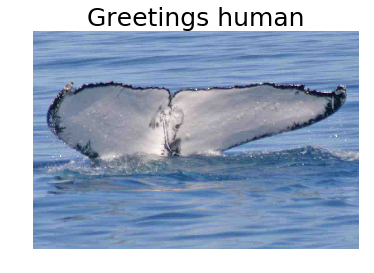

In [14]:
welcoming_whale = random_whale_image = plt.imread(get_random_whale_path())
image_plot = plt.imshow(welcoming_whale)
plt.axis("Off")
title = plt.title("Greetings human", fontsize=25)

<br>
### Training set images visualization

Create a function to retrieve n random whales from the dataset.

In [15]:
def get_random_whales(n):
    """Returns iterable of n lists of random whale images and whale id pairs from the training dataset
        [img_name1, img1], [img_name2, img2], ..., [img_name3, img3]
    """
    train_sample = train_df.sample(n)
    identifiers = [whale_id for whale_id in train_sample["Id"]]
    images = [plt.imread(f'{INPUT_DIR}/train/{image_name}')  for image_name in train_sample["Image"]]
    whales = zip(identifiers, images)
    return whales

<br>
Create a function to display n whales with the corresponding identifier.

In [16]:
def plot_random_whales(n):
    """Plots n random whales with the corresponding identifier
    """
    whales = get_random_whales(n)
    columns = 5
    rows = (n // columns) + 1
    width, height = columns * 3, rows * 3
    figure = plt.figure(figsize=(width,height))
    for i, whale in enumerate(whales):
        subplot = figure.add_subplot(rows,columns,i+1)
        subplot.axis("Off")
        plt.title(whale[0])
        plt.imshow(whale[1])

<br>
<a id="display_whales"> </a>
Let's see some whales


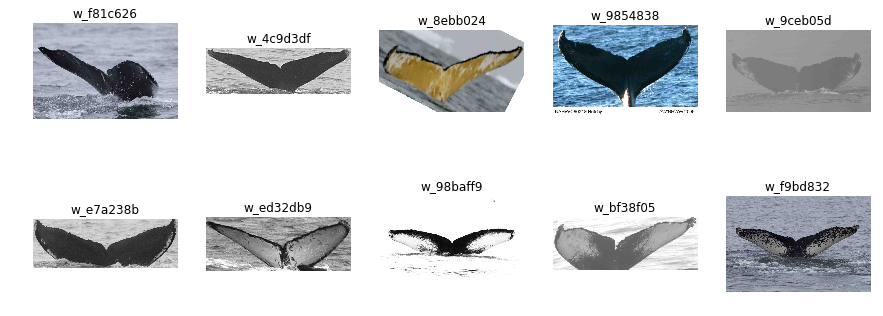

In [17]:
plot_random_whales(10)

<br>
## 3.3 Labeled dataset data analysis

### Number of training examples and categories

In [27]:
n_train_images = train_df["Image"].count()
categories = train_df["Id"].unique()
n_categories = len(train_df["Id"].unique())
ratio_images_per_category = round(n_train_images / n_categories, 2)
print(f"Number of training images: {n_train_images}")
print(f"Number of categories: {n_categories}")
print(f"Average images per category: {ratio_images_per_category}")

Number of training images: 9850
Number of categories: 4251
Average images per category: 2.32


As we can see, we don't have many test cases per category.

<br>
### Number of images per category

We count the number of images each category has (images_per_category). <br>
We compute the pair of lists:
 - number of images
 - number of categories with that number of images.

In [19]:
images_per_category = train_df["Id"].value_counts().values
n_images, n_categories_with_n_images = np.unique(images_per_category, return_counts=True)

In [20]:
print(f"{n_train_images} training images")

print( "Nbr of samples/class\tNbr of classes")
for i in range(len(n_categories_with_n_images)):
    print(f"{n_images[i]}\t\t\t{n_categories_with_n_images[i]}")

9850 training images
Nbr of samples/class	Nbr of classes
1			2220
2			1034
3			492
4			192
5			102
6			61
7			40
8			23
9			21
10			9
11			7
12			7
13			9
14			5
15			4
16			5
17			4
18			2
19			2
20			1
21			3
22			3
23			1
26			1
27			1
34			1
810			1


Plot a histogram to visualize it better.

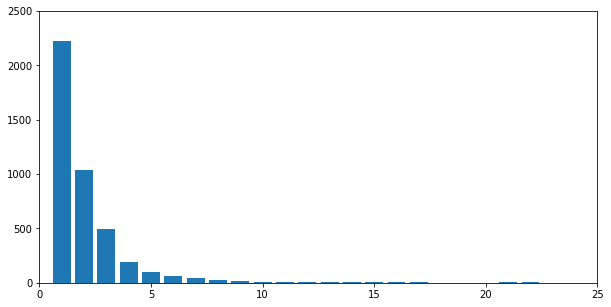

In [21]:
plt.figure(figsize=(10, 5))
plt.bar(n_images, n_categories_with_n_images)
plt.axis((0,25,0,2500))
plt.show()

<br>
One huge problem with this dataset is the number of images per category. Most categories have 1 or 2 images.
 - It's very hard to generalize from such small number of cases
 - If we include all the images for one particular category in the validation set, then the training set won't have that category. (this will break our model as we will see later)

<br>
### Sizes of the images

Let's plot the most common sizes of the training set

In [22]:
# Create a counter object with the sizes of the training set images
img_sizes_freqs = Counter([Image.open(f'{INPUT_DIR}//train//{i}').size for i in train_df['Image']])
# Extract the 10 most common sizes
img_sizes_freqs.most_common(10)

[((1050, 600), 1113),
 ((1050, 700), 951),
 ((1050, 450), 409),
 ((1050, 525), 371),
 ((700, 500), 200),
 ((1000, 667), 122),
 ((1050, 630), 114),
 ((1000, 652), 85),
 ((900, 600), 72),
 ((1050, 599), 44)]

Plot a histogram to visualize it better.

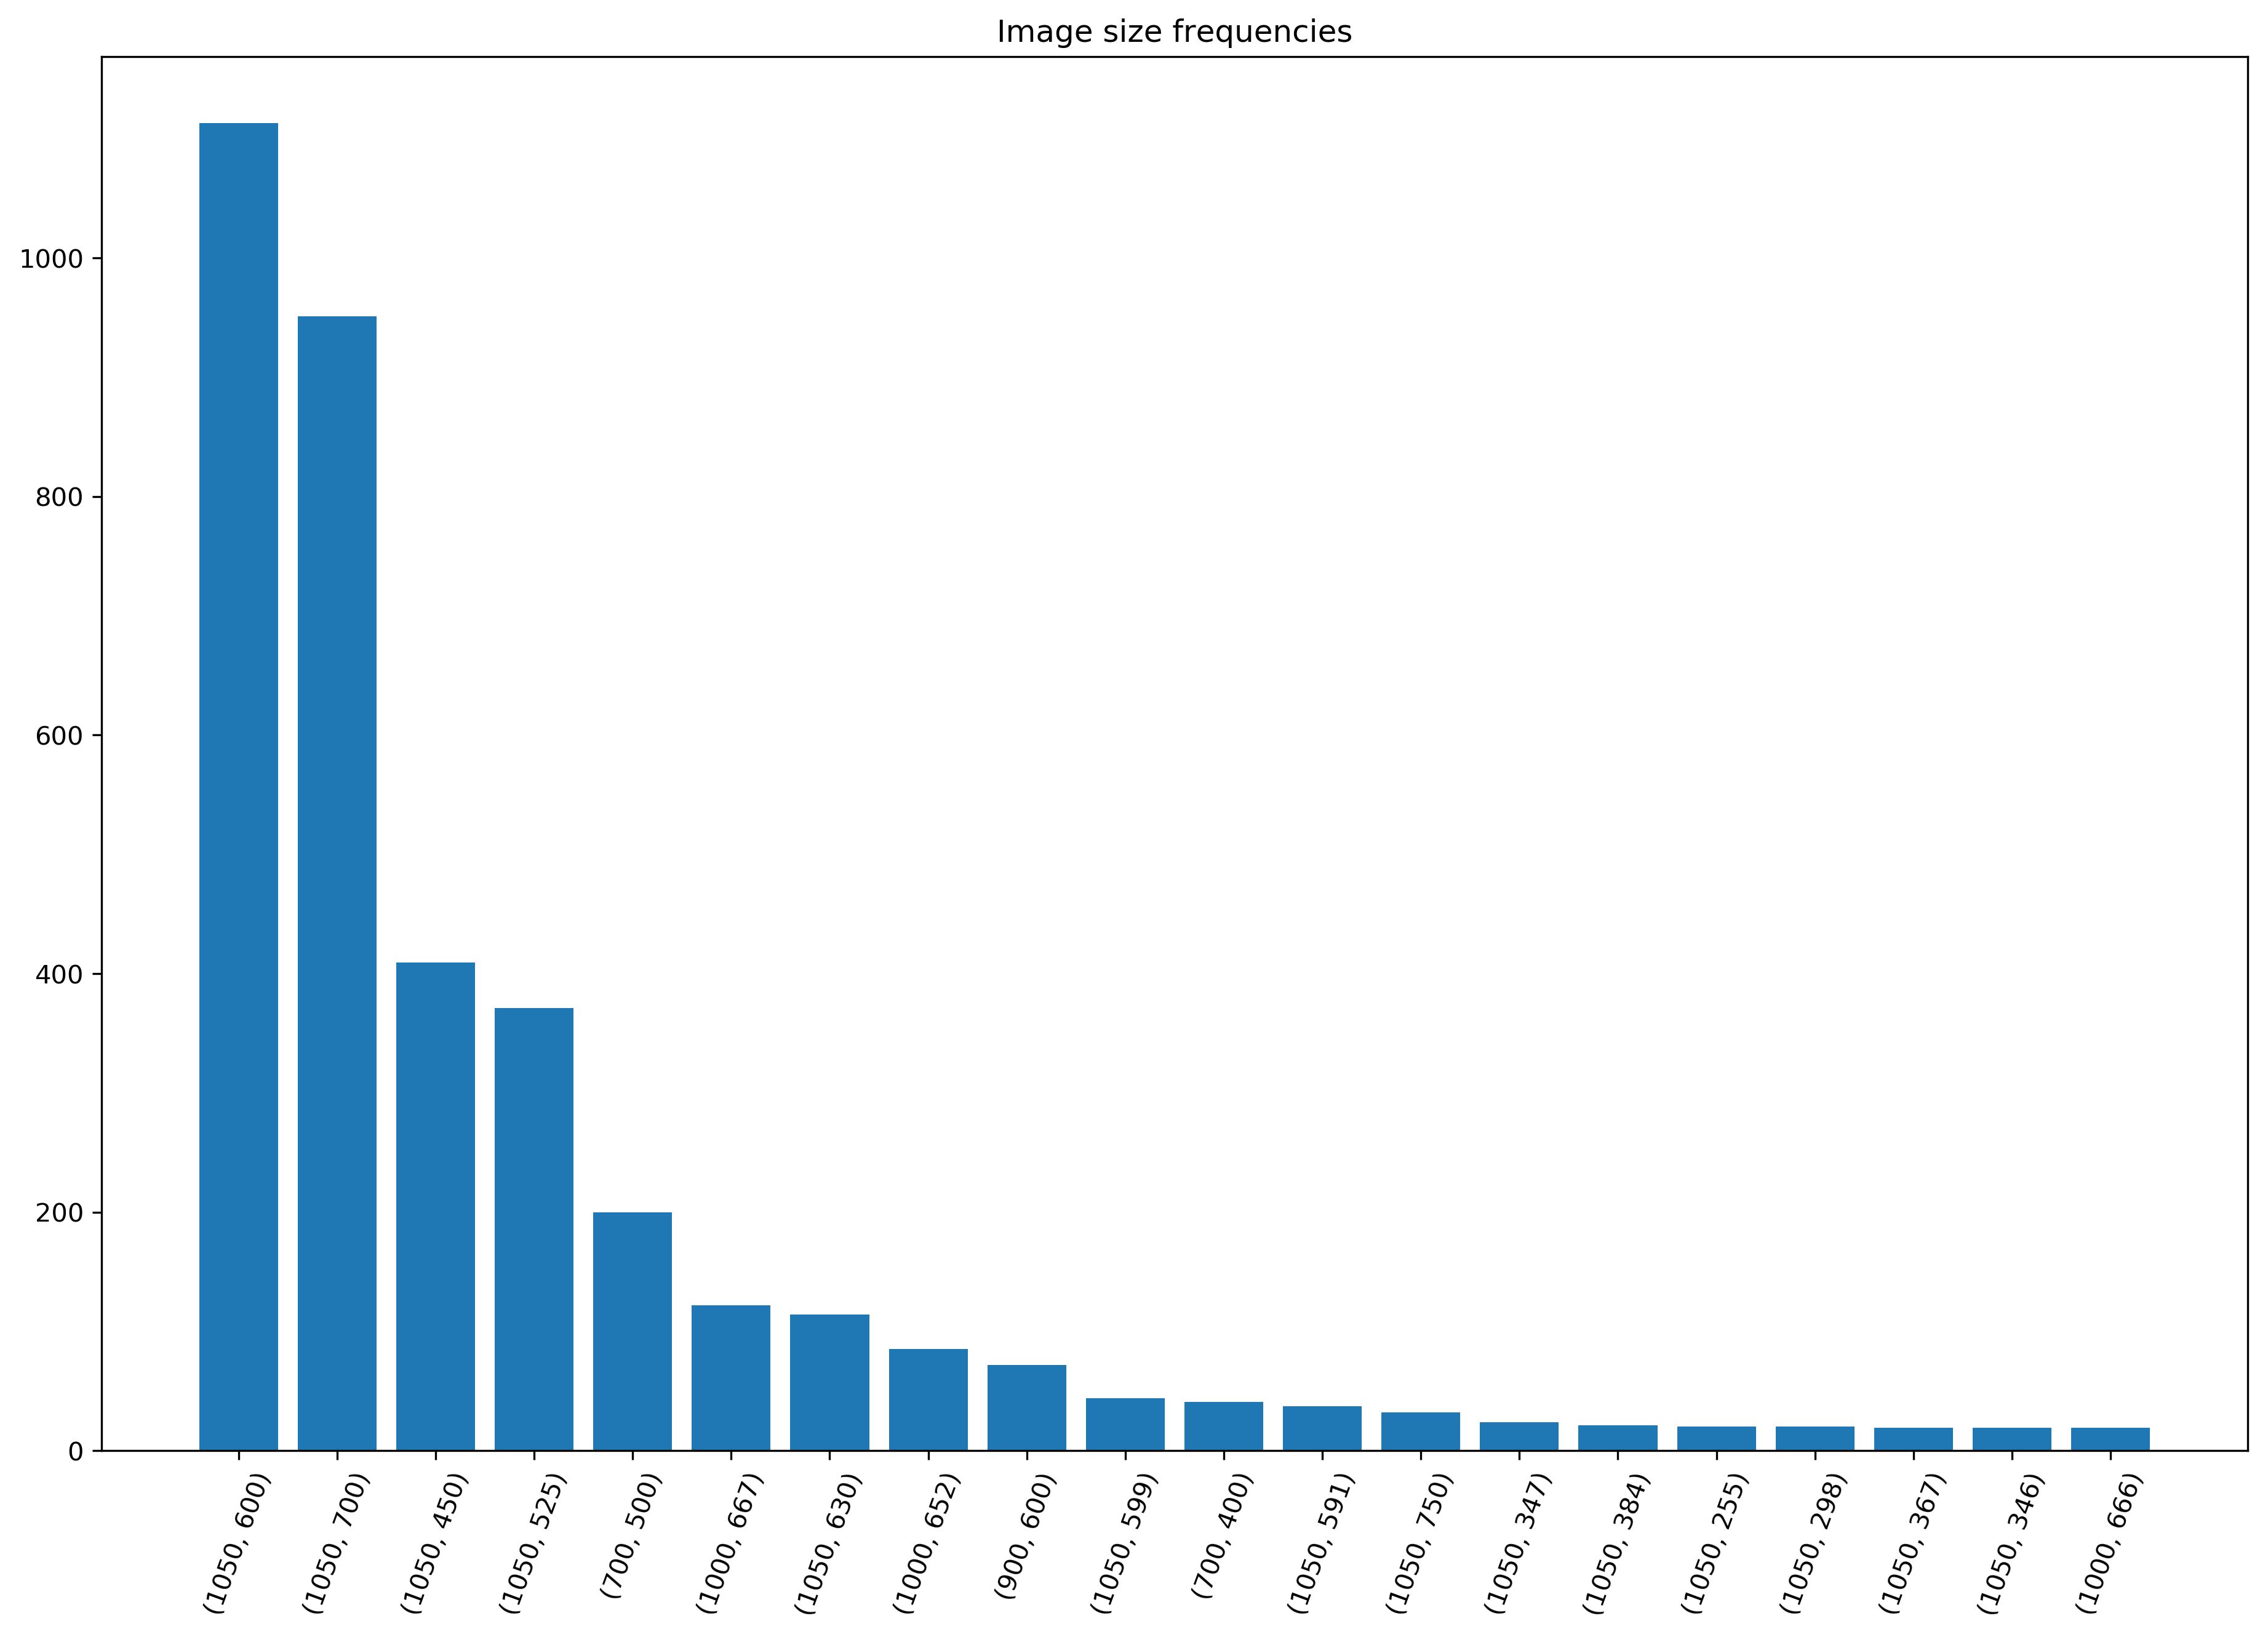

In [23]:
sizes = [img_size_freq[0] for img_size_freq in img_sizes_freqs.most_common(20)]
freqs = [img_size_freq[1] for img_size_freq in img_sizes_freqs.most_common(20)]
plt.figure(figsize=(15,10), dpi=300)
plt.bar(range(len(freqs)), freqs, align="center")
plt.xticks(range(len(sizes)), sizes, rotation = 70)
plt.title("Image size frequencies")
plt.show()

Sizes vary way more in height than in width. We will take this in mind for data augmentation.

<br>
### Greyscale images percentatge

It may be useful to know what percentage of images are in greyscale.<br>
In order to do that, we can use the following function.

In [24]:
def is_grey_scale(img_path):
    """Thanks to https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli"""
    im = Image.open(img_path).convert('RGB')
    w,h = im.size
    for i in range(w):
        for j in range(h):
            r,g,b = im.getpixel((i,j))
            if r != g != b: return False
    return True

The previous function is really slow so we will calculate the greyscale percentage over a sample rather than the whole dataset.

In [25]:
def greyscale_percentage_dataset(sample_size):
    greyscale = 0
    for image_filename in train_df["Image"].sample(sample_size):
        image_path = f"{INPUT_DIR}\\train\\{image_filename}"
        if is_grey_scale(image_path):
            greyscale += 1
    return round(greyscale / sample_size, 3) * 100

In [159]:
greyscale_percentage_dataset(30)

50.0

As we can see the greyscale percentage is quite high. We will take this in mind for data augmentation.

<br>
<br>
# 4 . Data augmentation

Because we have so few training cases per category we need to do some aggressive data augmentation. This way we can achieve:
<ul>
    <li> Better generalization of the model (performance)
    <li> A proper training and validation set to fine tune the model
</ul>


The pipeline for data augmentation is described as follows:
 - Get an array with the categories.
 - For each category, obtain a list with the filenames.
 - Define the function to apply a transformation to an image.
 - Define the function to apply the transformations to the dataset.

## Generate the dictionary {category : [image filenames]}

The objective is to obtain a dictionary that links each category to all the image filenames belonging to that category.<br>

As a reminder, we already defined an array containing the categories.

In [28]:
categories

array(['w_e15442c', 'w_1287fbc', 'w_da2efe0', ..., 'w_6249155', 'w_2ceab05', 'w_b9bfd4e'], dtype=object)

Create a dataframe of all the image filenames that belong to a particular category. The following statement could be read as:<br>
Localize all the "Image" elements where the "Id" element equals to the category and create a dataframe.

In [29]:
category_df = train_df.loc[train_df["Id"] == categories[2], ["Image"]] # categories[2] is just a random category
category_df

,Image
2,00087b01.jpg
1094,1c2e3696.jpg
1542,28ff06e7.jpg
1704,2d1f2fd3.jpg
2369,3db2b50d.jpg
4237,6f3b1c6d.jpg
5023,82987a45.jpg
6314,a40da07c.jpg
6784,b002c2c3.jpg
6917,b35cb9b8.jpg


Then we select the elements from the "Image" column and cast them to a list.

In [30]:
category_image_filenames = list(category_df["Image"])
category_image_filenames

['00087b01.jpg',
 '1c2e3696.jpg',
 '28ff06e7.jpg',
 '2d1f2fd3.jpg',
 '3db2b50d.jpg',
 '6f3b1c6d.jpg',
 '82987a45.jpg',
 'a40da07c.jpg',
 'b002c2c3.jpg',
 'b35cb9b8.jpg',
 'bd912af5.jpg']

Putting all together with dictionary comprehension

In [31]:
category_filenames_dict = {category : list(train_df.loc[train_df["Id"] == category, ["Image"]]["Image"]) for category in categories}

We just created a dictionary that links a category to the image filenames.

In [98]:
category_filenames_dict[categories[0]]

['00022e1a.jpg']

## Data augmentation with keras

Define the data generator instance that will apply the transformations to our dataset.

## Transformations for data augmentation

There are quite a few options when it comes to transformations. In this section I will go over the most used so we develop an intuition.

We are going to use Keras for data augmentation. Keras includes a ImageDataGenerator object to create augmented images.<br>


In [33]:
data_generator = ImageDataGenerator(
                    rotation_range=90,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

Let's load an image

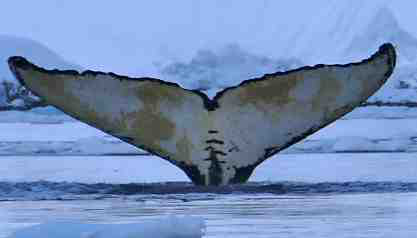

In [34]:
original_image_path = f'{INPUT_DIR}\\train\\{train_df["Image"][50]}'
keras_img = load_img(original_image_path)
keras_img

Let's create a batch of augmented images from that previous image

Keras needs the image in an array shape to perform data augmentation.<br>
Keras works with batches, for that reason if we are using only one image, we must add another dimension manually (n_images, RGB, width, height).

In [35]:
img_array = img_to_array(keras_img)  # this is a Numpy array with shape (3, width, height)
batch_array = img_array.reshape((1,) + img_array.shape)  # this is a Numpy array with shape (1, 3, width, height)

In [36]:
def keras_batch_from_image_path(image_path):
    keras_img = load_img(image_path)
    img_array = img_to_array(keras_img)
    batch_array = img_array.reshape((1,) + img_array.shape)
    return batch_array
    

We will use the tmp_images directory to store the tests and data visualization images.<br>

In [37]:
TMP_IMAGES_PATH = f'{INPUT_DIR}\\tmp_images'

First, we create a function to eliminate the contents of the tmp_images directory

In [38]:
def clear_tmp_images_directory():
    tmp_images_files = os.listdir(TMP_IMAGES_PATH)
    for file in tmp_images_files:
        os.remove(f"{TMP_IMAGES_PATH}\\{file}")
    return "Directory clear"

Test the function.

In [39]:
print(clear_tmp_images_directory())
os.listdir(f"{INPUT_DIR}\\tmp_images")

Directory clear


[]

Create a function to generate augmented images

In [40]:
def generate_augmented_images(batch_array, data_generator, n_augmented_images, output_dir):
    i = 0
    for batch in data_generator.flow(batch_array, batch_size=1, 
                                     save_to_dir=output_dir, save_prefix='test', save_format='jpeg'):
        i += 1
        if i >= n_augmented_images:
            break

Create 5 augmented images in the tmp_images directory.

In [41]:
generate_augmented_images(batch_array, data_generator, 5, TMP_IMAGES_PATH)

In [103]:
def augment_image(image_path, augmentations_output_path, n_augmentations, data_generator):
    batch_array = keras_batch_from_image_path(image_path)
    generate_augmented_images(batch_array, data_generator, n_augmentations, augmentations_output_path)

Create the function to display the original and the augmented images

In [42]:
def load_images_from_folder(folder_path):
    images_filenames = os.listdir(folder_path)
    images = [plt.imread(f'{folder_path}\\{image_filename}')  for image_filename in images_filenames]
    return images

In [43]:
def display_single_image(image):
    figure = plt.figure(figsize=(10,5))
    plt.title("Original image")
    plt.axis("Off")
    plt.imshow(image)

In [44]:
def display_images(images):
    n = len(images)
    columns = 5
    rows = (n // columns) + 1
    width, height = columns * 3, rows * 3
    figure = plt.figure(figsize=(width,height))
    for i, image in enumerate(images):
        subplot = figure.add_subplot(rows,columns,i+1)
        subplot.axis("Off")
        plt.title("")
        plt.imshow(image)
    
    

Testing the display functions

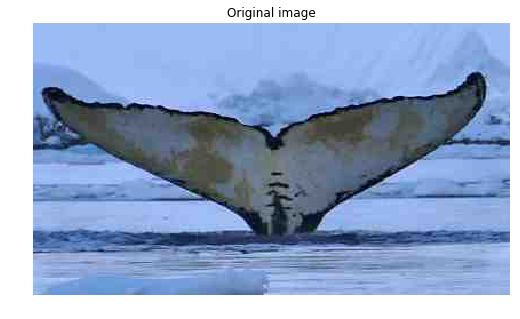

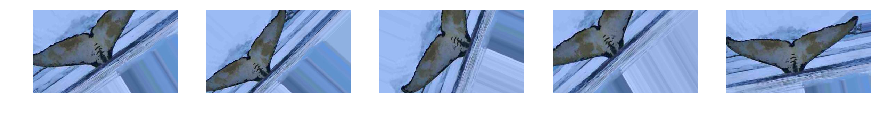

In [45]:
TEST_IMAGES_DIR = f"{INPUT_DIR}\\tmp_images"
original_image =  plt.imread(original_image_path)
augmented_images = load_images_from_folder(f"{INPUT_DIR}\\tmp_images")
display_single_image(original_image)
display_images(augmented_images)

It would be useful to have a function which will take as parameters a data generator, an image and the number of augmentations and it will output the original image and the augmentations.

In [46]:
def generate_augmentations_and_display(image_path, data_generator, n_augmentations):
    clear_tmp_images_directory()
    batch_array = keras_batch_from_image_path(image_path)
    generate_augmented_images(batch_array, data_generator, n_augmentations, TMP_IMAGES_PATH)
    original_image =  plt.imread(image_path)
    augmentations = load_images_from_folder(TMP_IMAGES_PATH)
    display_single_image(original_image)
    display_images(augmentations)

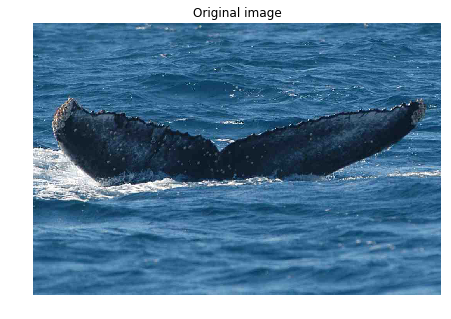

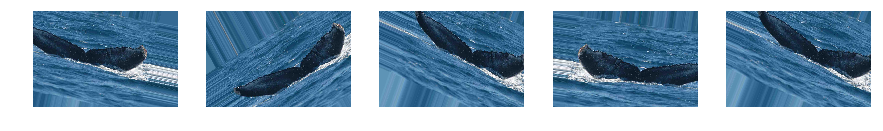

In [47]:
generate_augmentations_and_display(get_random_whale_path(), data_generator, 5)

<a href="#display_whales">Display some whales</a>

## Rotation range

The first augmentation we are going to cover is rotation. As it name suggests it rotates the image (duh).<br>
Checking some images from the dataset most of them are quite leveled. Some are slightly tilt, but not that much.<br>
I think 10º degrees is a reasonable choice.

In [48]:
rotation_data_generator = ImageDataGenerator(
                    rotation_range=10,
                    fill_mode='nearest')

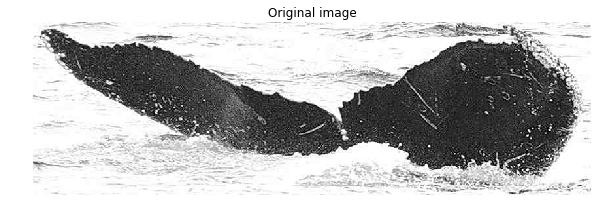

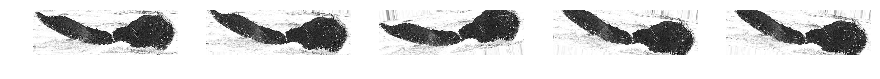

In [49]:
generate_augmentations_and_display(get_random_whale_path(), rotation_data_generator, 5)

## Shift range

Shift augmentations simply move the image horizontally and vertically.
Most images are quite centered and don't have huge margins so a small shift should do.<br>
After some testing 0.05 for width and 0.1 for height seem to do fine.

In [50]:
shift_data_generator = ImageDataGenerator(
                    width_shift_range=0.05,
                    height_shift_range=0.1,
                    fill_mode='nearest')

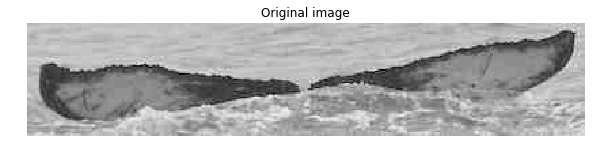

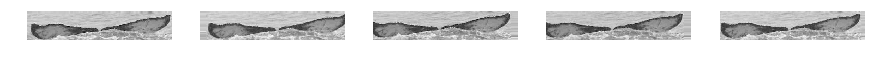

In [51]:
generate_augmentations_and_display(get_random_whale_path(), shift_data_generator, 5)

## Shear range

Shear stretches one side of an image from the other (it's hard to explain, just google shear augmentation). It kind of represents small movements on the viewer perspective. This goes very well with our dataset as not all whales appear directly in front of us.<br>
A shear of 3 looks good to me.

In [52]:
shear_data_generator = ImageDataGenerator(
                    shear_range=3,
                    fill_mode='nearest')

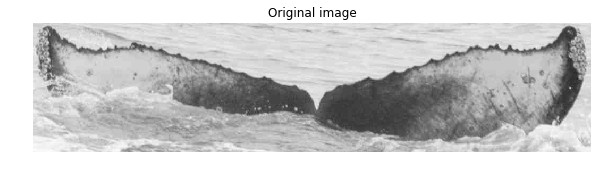

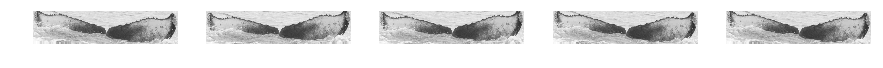

In [53]:
generate_augmentations_and_display(get_random_whale_path(), shear_data_generator, 5)

## Zoom range

Yep, does exactly that.
Because we don't have huge margins, 0.1 is enough.

In [54]:
zoom_data_generator = ImageDataGenerator(
                    zoom_range=0.1,
                    fill_mode='nearest')

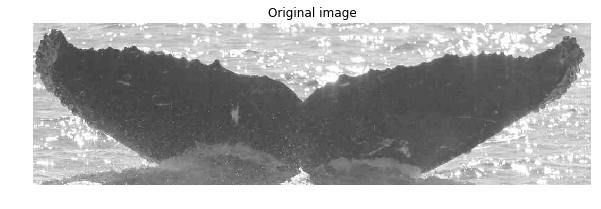

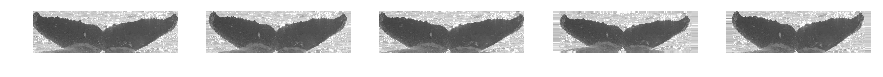

In [55]:
generate_augmentations_and_display(get_random_whale_path(), zoom_data_generator, 5)

## Flip and fill mode

As a friend pointed out, it doesn't make sense to flip the image because that would change the morphology of that whale.
I've tested the fill modes and the best one seems to be "nearest". The other fill modes make random flukes appear.

## Putting all the augmentations together

Let's see all the augmentations together!

In [56]:
complete_data_generator = ImageDataGenerator(
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.1,
                    shear_range=3,
                    zoom_range=0.1,
                    fill_mode='nearest')

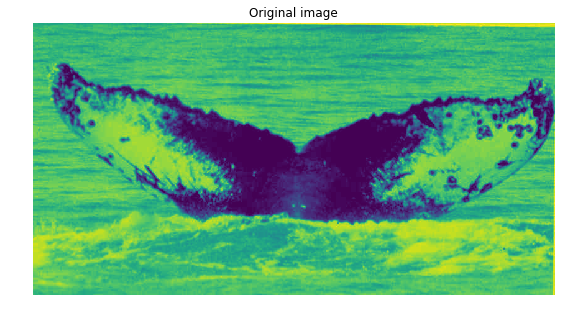

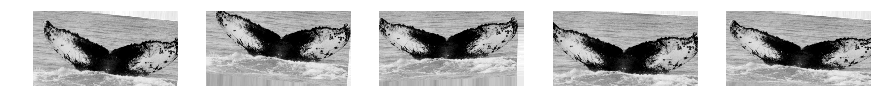

In [57]:
generate_augmentations_and_display(get_random_whale_path(), complete_data_generator, 5)

## Create the augmented training dataset

Now we will focus on augmenting the dataset into a different folder.<br>
For that purpose we will have at least 10 images per category.<br>

In [76]:
TRAIN_PATH = f'{INPUT_DIR}\\train'
TRAIN_AUG_PATH = f'{INPUT_DIR}\\train_aug'

In [86]:
def clear_train_aug_images_directory():
    aug_images_files = os.listdir(TRAIN_AUG_PATH)
    for file in aug_images_files:
        shutil.rmtree(f"{TRAIN_AUG_PATH}\\{file}")
    return "Directory clear"

In [87]:
clean_train_aug_dir = True
if clean_train_aug_dir:
    clear_train_aug_images_directory()

In [73]:
def create_categories_folders_train_aug(categories):
    for category in categories:
        os.mkdir(f'{TRAIN_AUG_PATH}\\{category}')

In [101]:
create_categories_folders_train_aug(categories)

In [75]:
print(len(os.listdir(TRAIN_AUG_PATH)))

4251


In [99]:
def move_images_category(input_path, output_path, category):
    images_filenames = category_filenames_dict[category]
    for image_filename in images_filenames:
        shutil.copy(f'{input_path}\\{image_filename}', f'{output_path}\\{category}\\{image_filename}')
        

In [127]:
category_filenames_dict[categories[7]]

['0031c258.jpg',
 '007c3603.jpg',
 '00863b8c.jpg',
 '00aa021c.jpg',
 '00ad9219.jpg',
 '00ded600.jpg',
 '012621f1.jpg',
 '01cf2e2e.jpg',
 '02715625.jpg',
 '02aceb16.jpg',
 '036b9b64.jpg',
 '037e59bc.jpg',
 '03933dbb.jpg',
 '03c6a5c0.jpg',
 '03de1a54.jpg',
 '04a39247.jpg',
 '04ad14b2.jpg',
 '04d7f905.jpg',
 '051e6fbe.jpg',
 '0524950b.jpg',
 '053555fe.jpg',
 '0592e297.jpg',
 '05a273d8.jpg',
 '05e50d1a.jpg',
 '05ee4ba3.jpg',
 '05f4fd87.jpg',
 '06194c8f.jpg',
 '06e622e0.jpg',
 '07b8a5e7.jpg',
 '07ecc5ba.jpg',
 '086cc275.jpg',
 '08b62734.jpg',
 '09394b01.jpg',
 '094a67d1.jpg',
 '0a00c8c5.jpg',
 '0ada5fa1.jpg',
 '0aed1250.jpg',
 '0b635230.jpg',
 '0bfb2b72.jpg',
 '0c11fa0c.jpg',
 '0c88a7aa.jpg',
 '0c8983f3.jpg',
 '0cd6cc7b.jpg',
 '0d10de68.jpg',
 '0d482f6b.jpg',
 '0df85a56.jpg',
 '0e5996a4.jpg',
 '0e6ac93b.jpg',
 '0f550bb8.jpg',
 '0fa288cf.jpg',
 '0fb6482b.jpg',
 '0fd95216.jpg',
 '0ffa7cf0.jpg',
 '104713f3.jpg',
 '104ef864.jpg',
 '10807a6e.jpg',
 '109d1dc5.jpg',
 '10ae4f14.jpg',
 '10bd94ea.jpg

In [95]:
move_images_category(TRAIN_PATH, TRAIN_AUG_PATH, categories[2])

FileNotFoundError: [WinError 3] The system cannot find the path specified: '.\\input\\train\\00087b01.jpg' -> '.\\input\\train_aug\\w_da2efe0\\00087b01.jpg'

In [100]:
def move_images_categories(input_path, output_path, categories):
    for category in categories:
        move_images_category(input_path, output_path, category)

In [102]:
move_images_categories(TRAIN_PATH, TRAIN_AUG_PATH, categories)

In [129]:
def augment_category(category, category_filenames_dict, n_minimum_images, data_generator):
    original_images = category_filenames_dict[category]
    n_original_images = len(original_images)
    n_minimum_augmentations = n_minimum_images - n_original_images
    if n_minimum_augmentations > 0:
        n_augmentations_image = (n_minimum_augmentations // n_original_images) + 1
        for original_image in original_images:
            augment_image(f'{TRAIN_PATH}\\{original_image}', f'{TRAIN_AUG_PATH}\\{category}', n_augmentations_image, data_generator)
    
    
    

In [110]:
augment_category(categories[0], category_filenames_dict, 6, complete_data_generator)

In [128]:
categories[7]

'new_whale'

In [123]:
def augment_all_categories(categories, category_filenames_dict, n_minimum_images, data_generator):
    for i in tqdm(range(len(categories))):
        category = categories[i]
        augment_category(category, category_filenames_dict, n_minimum_images, data_generator)

In [130]:
augment_all_categories(categories, category_filenames_dict, 6, complete_data_generator)


  0%|          | 12/4251 [00:04<24:03,  2.94it/s]
Exception in thread Thread-13:
Traceback (most recent call last):
  File "C:\Users\David\Anaconda3\envs\fastai-cpu\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\David\Anaconda3\envs\fastai-cpu\lib\site-packages\tqdm\_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\David\Anaconda3\envs\fastai-cpu\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 4251/4251 [41:15<00:00,  1.72it/s]


<br>
<br>
# 4. Model training

Building a successful neural network is an iterative process. We shouldn't expect to come up with a magical idea that will make a great network from the start. Also, we shouldn't make decisions based on "gut feelings" or "divine visions".

<br>
## 4.1 First iteration: Basic Model

My first priority is to build a basic and dirty classifier that will output something.
That something doesn't have to be great, it can be just above garbage, but that's more than enough to extract some metrics that will drive our decisions much better.
For that reason, I won't bother for augmentations, tricky algorithms or anything more than the very basics at this point. I will just focus on predicting something I can upload to kaggle.

### Architecture
The chosen architecture is resnet34, it comes pretrained with a huge imagenet dataset and it's not too complex.

In [5]:
arch = resnext50

### Transformations size
Resnet34 was trained on mostly 224·224 to 300·300 images sizes. For that reason, transforming the training images to that size should result in decent result.

In [6]:
tfms = tfms_from_model(arch, 299)

### Validation set

As explained earlier, because we have so many categories with only one example, using a validation set will probably result in a training set that doesn't include all categories.
Therefore, the trained network won't have the right output dimension, thus our predictions won't be of any use.
So what can we do in this situation? We will train the network in 2 steps:
<ol>
<li> We will use a standard 20% of the dataset as a validation set to find a good learning rate.
<li> We will train the network with that learning rate on the whole dataset. 
</ol>

In [31]:
step = 1
if step == 1:
    val_idxs = get_cv_idxs(n_train_images, val_pct=0.001)
# The fastai library requires at least one image for the validation set. A new whale image is used
elif step == 2:
    new_whale_index = train_df.loc[train_df.Id =="new_whale", "Image"].index[0]
    val_idxs = np.array([cal_idxs])

### Data transformation
Now we can adapt the training set images to train a neural net based on the previous options.<br>
We don't have folders for each category so we will create the data from the csv file.

In [8]:
data = ImageClassifierData.from_paths(path="./input", trn_name="train_aug", test_name="test", tfms=tfms)

### Learning rate
Create a pretrained convolutional neural network instance. 

In [11]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 244/244 [07:05<00:00,  1.74s/it]


In [10]:
os.listdir(f'{INPUT_DIR}/train')

['00022e1a.jpg',
 '000466c4.jpg',
 '00087b01.jpg',
 '001296d5.jpg',
 '0014cfdf.jpg',
 '0025e8c2.jpg',
 '0026a8ab.jpg',
 '0031c258.jpg',
 '0035632e.jpg',
 '0037e7d3.jpg',
 '00389cd7.jpg',
 '0042dcc4.jpg',
 '0042ea34.jpg',
 '00467ae9.jpg',
 '004a97f3.jpg',
 '004c5fb9.jpg',
 '005c57e7.jpg',
 '006d0aaf.jpg',
 '0078af23.jpg',
 '007c3603.jpg',
 '00863b8c.jpg',
 '008809b5.jpg',
 '008baccf.jpg',
 '0091c92b.jpg',
 '009dca38.jpg',
 '00a29f63.jpg',
 '00aa021c.jpg',
 '00ab018e.jpg',
 '00ac0e86.jpg',
 '00acb5a9.jpg',
 '00ad9219.jpg',
 '00af84d8.jpg',
 '00b2c0cd.jpg',
 '00b588d6.jpg',
 '00b7de10.jpg',
 '00be7f73.jpg',
 '00be9148.jpg',
 '00cf7bd3.jpg',
 '00d3d48c.jpg',
 '00d6b82e.jpg',
 '00ded600.jpg',
 '00eab0e6.jpg',
 '00ec0dcd.jpg',
 '00f22419.jpg',
 '00f4c92c.jpg',
 '0101d22b.jpg',
 '010ecbb5.jpg',
 '010f1fe2.jpg',
 '011904f8.jpg',
 '01228da4.jpg',
 '012621f1.jpg',
 '01274a1e.jpg',
 '01321d88.jpg',
 '01496f0b.jpg',
 '0162c72f.jpg',
 '01679a6d.jpg',
 '01692e13.jpg',
 '0171d221.jpg',
 '0175c4c1.jpg

Compute the learning rate related info

In [12]:
learn.lr_find()

 87%|████████▋ | 466/533 [00:06<00:00, 71.00it/s, loss=38.9]


Our learning instance has a scheduler that exponentially increases the learning rate with each batch.<br>
Let's plot how this scheduler increases the learning rate with each iteration.

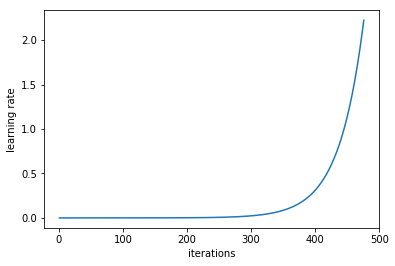

In [54]:
learn.sched.plot_lr()

Check how the loss decreases faster for a bigger learning rate until it becomes unstable.

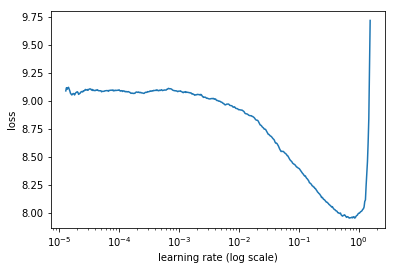

In [13]:
learn.sched.plot()

A learning rate of 0.1 seems like a reasonable choice.

### Training
Train the model with the chosen learning rate for 2 epochs or cycles.

In [14]:

learn.fit(lrs=0.01, n_cycle=2)

epoch      trn_loss   val_loss   accuracy                   
    0      7.490044   6.540001   0.108173  
    1      5.979151   4.639225   0.395471                   



[4.639225, 0.39547102757175689]

<br>
<br>
# 5. Model predictions

### 5.1 Understanding the output

We should be worried about the chosen activation function for our last layer, as it's nature is going to greatly define the neural network.<br>
Let's check out what the last layer activation function is.

In [38]:
learn[-1]

LogSoftmax()

The last layer outputs the logarithm of the softmax function of the activations of the previous layer (read that again).

In this case, the softmax function presents the following properties:
   - The sum of all the values of the output is equal to 1
   - It tends to "choose" only one category over the others exponentially

Now let's think about our current dataset. This neural network has to predict <b>which</b> whale is in the image.
So we could see our prediction as a mutual exclusion problem where it only makes sense to predict <b>one</b> whale.
This goes well with the properties of the softmax function, so it seems like a reasonable choice to use as the last layer.


#### Logarithm of the softmax function

$$L_i = \log\left(\frac{e^{i}}{ \sum_j e^{j} }\right)$$
The output of the softmax function ranges from 0 to 1:<br>
 - 0 corresponds to a very unlikely match<br>
 - 1 corresponds to an almost certain match

The output of the logarithm of the softmax function ranges from -inf to 0:<br>
 - -inf corresponds to a very unlikely match<br>
 - 0 corresponds to an almost certain match


### 5.2 Making the predictions

Important reminder. All the prediction related data of our neural network is contained in the data object we created in the model training.<br>
<ul>
    <li>To obtain the ordered classes we use the <b>data.classes</b> attribute.
    <li>To obtain the ordered test images we use the <b>data.test_ds.fnames</b> attribute.
</ul>

We set the is_test flag to True to tell the model to predict on the test set.<br>

In [35]:
test_name = "test"
test_predictions = learn.predict(is_test=True)

The prediction is represented as an array of predictions for each of the categories  sorted in the appearing order in data.test_ds.fnames.<br>
In this case, the model has 4251 categories, so the output for an image should be an array of 4251 items.<br>


In [36]:
print(f"The array of predictions for each category: {test_predictions[42]}")
print(f"The size of the array is: {np.size(test_predictions[42])}")

The array of predictions for each category: [-4.45667 -7.89754 -7.56598 ..., -9.02869 -7.61115 -8.77357]
The size of the array is: 4251


So the prediction for m test cases will result in a list of the predictions of each image for each category.<br>
It can be thought as an m*c matrix

In [37]:
np.shape(test_predictions)

(15610, 4251)

Check the output dimension is correct.

In [38]:
if np.shape(test_predictions)[1] != n_categories:
    print("FATAL ERROR, output dimension doesn't match the number of categories")
else:
    print("Output dimension correct")

Output dimension correct


### 5.3 Submission pipeline

In this kaggle competition, we are told to give the 5 more likely categories for each test case. The pipeline is described as follows:
 - Extract the 5 best predicted category indexes for each test case.
 - Match the indexes with the category.
 - Write our predictions in a csv file.


### 5.4 Extracting the categories indexes

In [39]:
def categories_indexes_wrapper(prediction):
    """Returns an array with the indexes of the 5 most likely categories
    for a prediction"""
    prediction_categories_index = np.argpartition(prediction, -5)[-5:]
    return prediction_categories_index

In [40]:
prediction_categories_index = list(map(categories_indexes_wrapper, test_predictions))
print(prediction_categories_index[42])

[3128 3745 4129 4192    0]


### 5.5 Linking the categories

Extract the categories identifiers from the categories indexes for a prediction.

In [41]:
def categories_from_index(prediction_categories_index):
    prediction_categories = [data.classes[index] for index in prediction_categories_index]
    return prediction_categories

Apply to all the predictions.

In [42]:
predicted_cat = list(map(categories_from_index, prediction_categories_index))
print(f"An example of a prediction: {predicted_cat[42]}")

An example of a prediction: ['w_bbe06a7', 'w_e17c752', 'w_f8d2cd9', 'w_fcfcf68', 'new_whale']


### 5.6 Creating the submission file

Following the submission example from kaggle we need:
 - a column with the names of the images with an "Image" header
 - a column with the 5 predicted space separated categories with an "Id" header

In [43]:
images_names_column = [image_file_name[5:] for image_file_name in data.test_ds.fnames]
predicted_categories_column = list(map(" ".join, predicted_cat))

In [44]:
print(data.classes[0:10])
print(list(categories[0:10]))

['new_whale', 'w_0013924', 'w_001ebbc', 'w_002222a', 'w_002b682', 'w_002dc11', 'w_0087fdd', 'w_008c602', 'w_009dc00', 'w_00b621b']
['w_e15442c', 'w_1287fbc', 'w_da2efe0', 'w_19e5482', 'w_f22f3e3', 'w_8b1ca89', 'w_eaad6a8', 'new_whale', 'w_3d0bc7a', 'w_50db782']


Construct the pandas dataframe.<br>
We need to define the order of the columns to match the submission example by kaggle.

In [45]:
predictions_df  = pd.DataFrame(data = {"Image":images_names_column, "Id": predicted_categories_column}, columns=["Image", "Id"])
predictions_df.head()

,Image,Id
0,00029b3a.jpg,w_b9417ee w_5a25156 w_488cdd8 w_73d5489 new_whale
1,0003c693.jpg,w_93b64e9 w_62c548b w_b197b5c w_61e1076 new_whale
2,000bc353.jpg,w_88c4d5e w_0ebd514 w_2486665 w_43be268 new_whale
3,0010a672.jpg,w_661dacb w_d775542 w_1287fbc w_abc2eda new_whale
4,00119c3f.jpg,w_89ee7c1 w_dbda0d6 w_1eafe46 new_whale w_ab4cae2


Define the submission name and path.

In [46]:
submission_filename = "submission8"
submission_path = f"{INPUT_DIR}\\submission\\{submission_filename}.csv"

Create the submission file without the index column.

In [47]:
predictions_df.to_csv(submission_path,index=False)

Generate a link to a direct download of the submission file.

In [193]:
FileLink(submission_path)

C:\Users\David\Desktop\Kaggle\happy_whale\input\submission\submission4.csv

### Conclusion

First submission got a 0.09264 score.<br>
Considering I didn't do any data augmentation or model specific training, it's not a bad result.<br> As I said, the first iteration only purpose was to create a solid pipeline.